In [2]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from category_encoders import OneHotEncoder


In [4]:
music = pd.read_csv('spotify-2023_utf8.csv')
music=music.drop(574).reset_index(drop=True)
music['streams'] = pd.to_numeric(music['streams'], errors='coerce')

In [5]:
music.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,9.520000e+02,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,1.556723,2018.288866,6.038866,13.944328,5202.565126,12.022059,5.141374e+08,67.866597,51.963235,2.669118,122.553571,66.984244,51.406513,64.274160,27.078782,1.582983,18.214286,10.138655
std,0.893331,11.011397,3.564571,9.197223,7901.400683,19.582405,5.668569e+08,86.470591,50.628850,6.038152,28.069601,14.631282,23.480526,16.558517,26.001599,8.414064,13.718374,9.915399
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,2.762000e+03,0.000000,0.000000,0.000000,65.000000,23.000000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,6.000000,874.500000,0.000000,1.416362e+08,13.000000,7.000000,0.000000,99.750000,57.000000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,13.000000,2216.500000,3.000000,2.905309e+08,34.000000,38.500000,0.000000,121.000000,69.000000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,5573.750000,16.000000,6.738690e+08,88.000000,87.000000,2.000000,140.250000,78.000000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,58.000000,206.000000,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


In [6]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            952 non-null    object
 1   artist(s)_name        952 non-null    object
 2   artist_count          952 non-null    int64 
 3   released_year         952 non-null    int64 
 4   released_month        952 non-null    int64 
 5   released_day          952 non-null    int64 
 6   in_spotify_playlists  952 non-null    int64 
 7   in_spotify_charts     952 non-null    int64 
 8   streams               952 non-null    int64 
 9   in_apple_playlists    952 non-null    int64 
 10  in_apple_charts       952 non-null    int64 
 11  in_deezer_playlists   952 non-null    object
 12  in_deezer_charts      952 non-null    int64 
 13  in_shazam_charts      902 non-null    object
 14  bpm                   952 non-null    int64 
 15  key                   857 non-null    ob

In [7]:
music.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

In [8]:
music_num = music[['artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_charts', 
       'bpm','danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']]

In [9]:
def multiplePlots( series ):

    fig, axs = plt.subplots(2,2)
    plt.tight_layout(pad=0.4, w_pad=4, h_pad=1.0)
    axs[0,0].set_title("Series "+ series.name)

    # Histogram
    sns.histplot(x=series, ax=axs[0,0])

    # Lag plot
    lag = series.copy()
    lag = np.array(lag[:-1])
    current = series[1:]
    ax = sns.regplot(x=current,y=lag,fit_reg=False, ax=axs[0,1])
    ax.set_ylabel("y_i-1")
    ax.set_xlabel("y_i")

    # QQ plot
    qntls, xr = stats.probplot(series, fit=False)
    sns.regplot(x=xr,y=qntls, ax=axs[1,0])

    # Run sequence
    ax = sns.regplot(x=np.arange(len(series)),y=series, ax=axs[1,1])
    ax.set_ylabel("val")
    ax.set_xlabel("i")

    plt.show()

c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


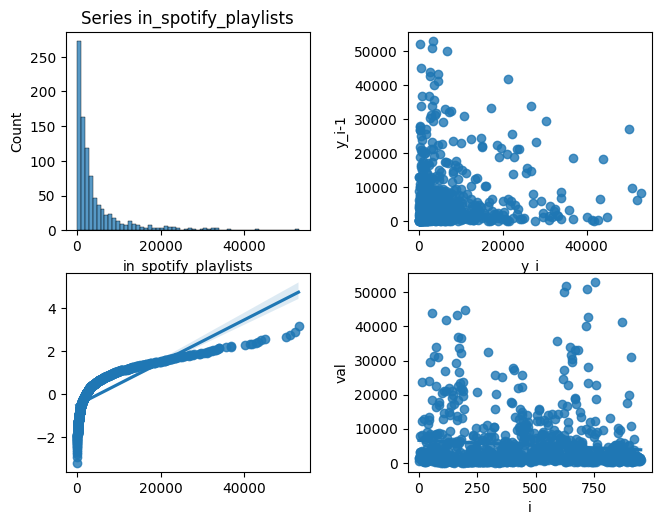

5202.56512605042 7901.400683370075


c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


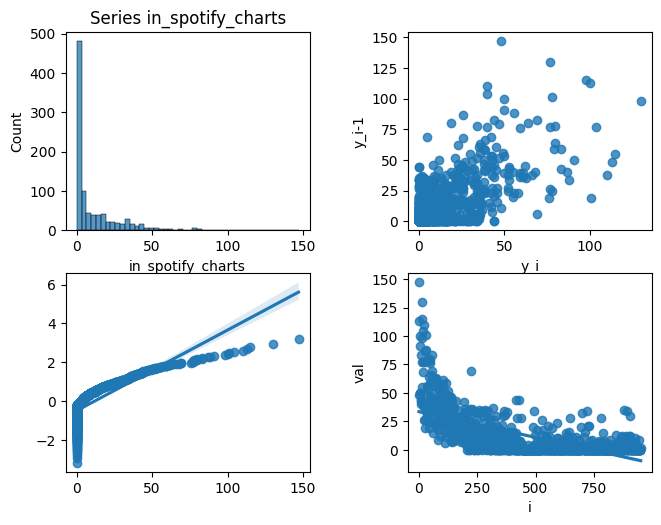

12.022058823529411 19.582405265112186


c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


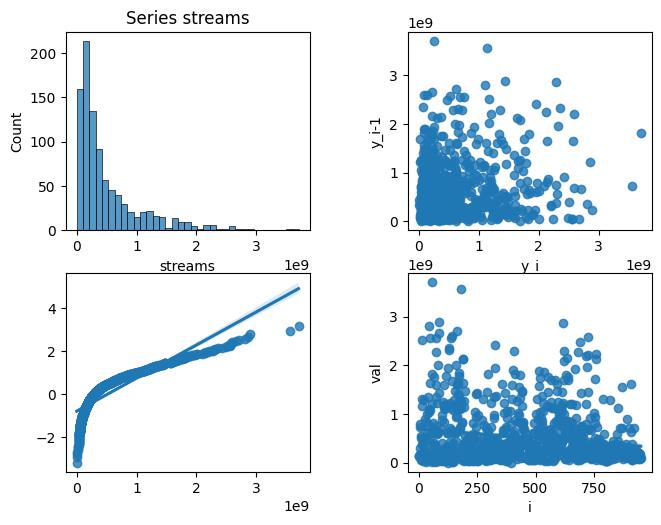

514137424.93907565 566856949.038883


c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


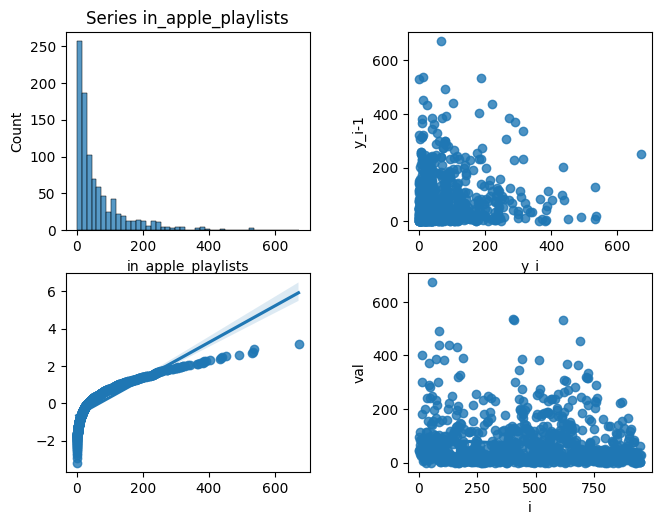

67.86659663865547 86.4705906483819


c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


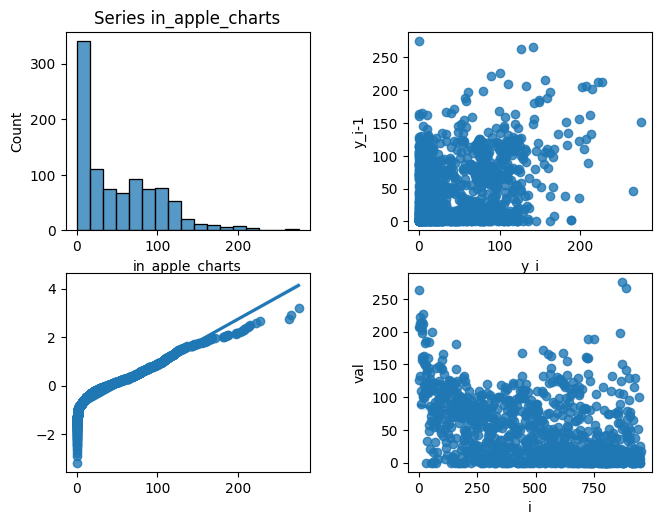

51.963235294117645 50.62885003194935


c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


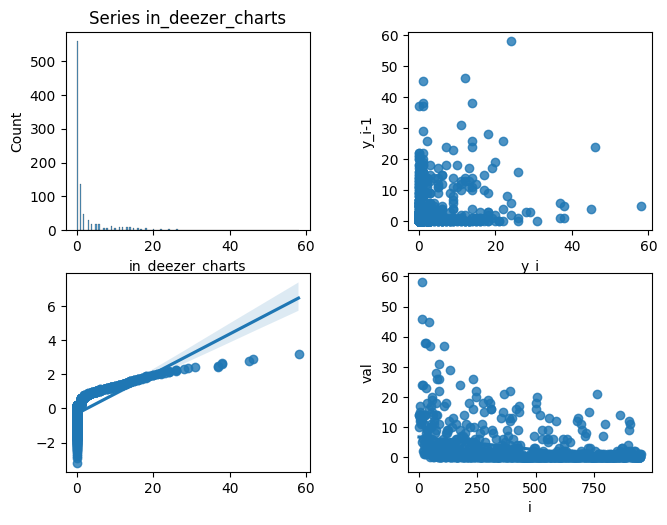

2.6691176470588234 6.0381517547055195


In [30]:
for i in range (4,10):
    multiplePlots(music_num.iloc[:,i])
    print(music_num.iloc[:,i].mean(), music_num.iloc[:,i].std())

c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_d

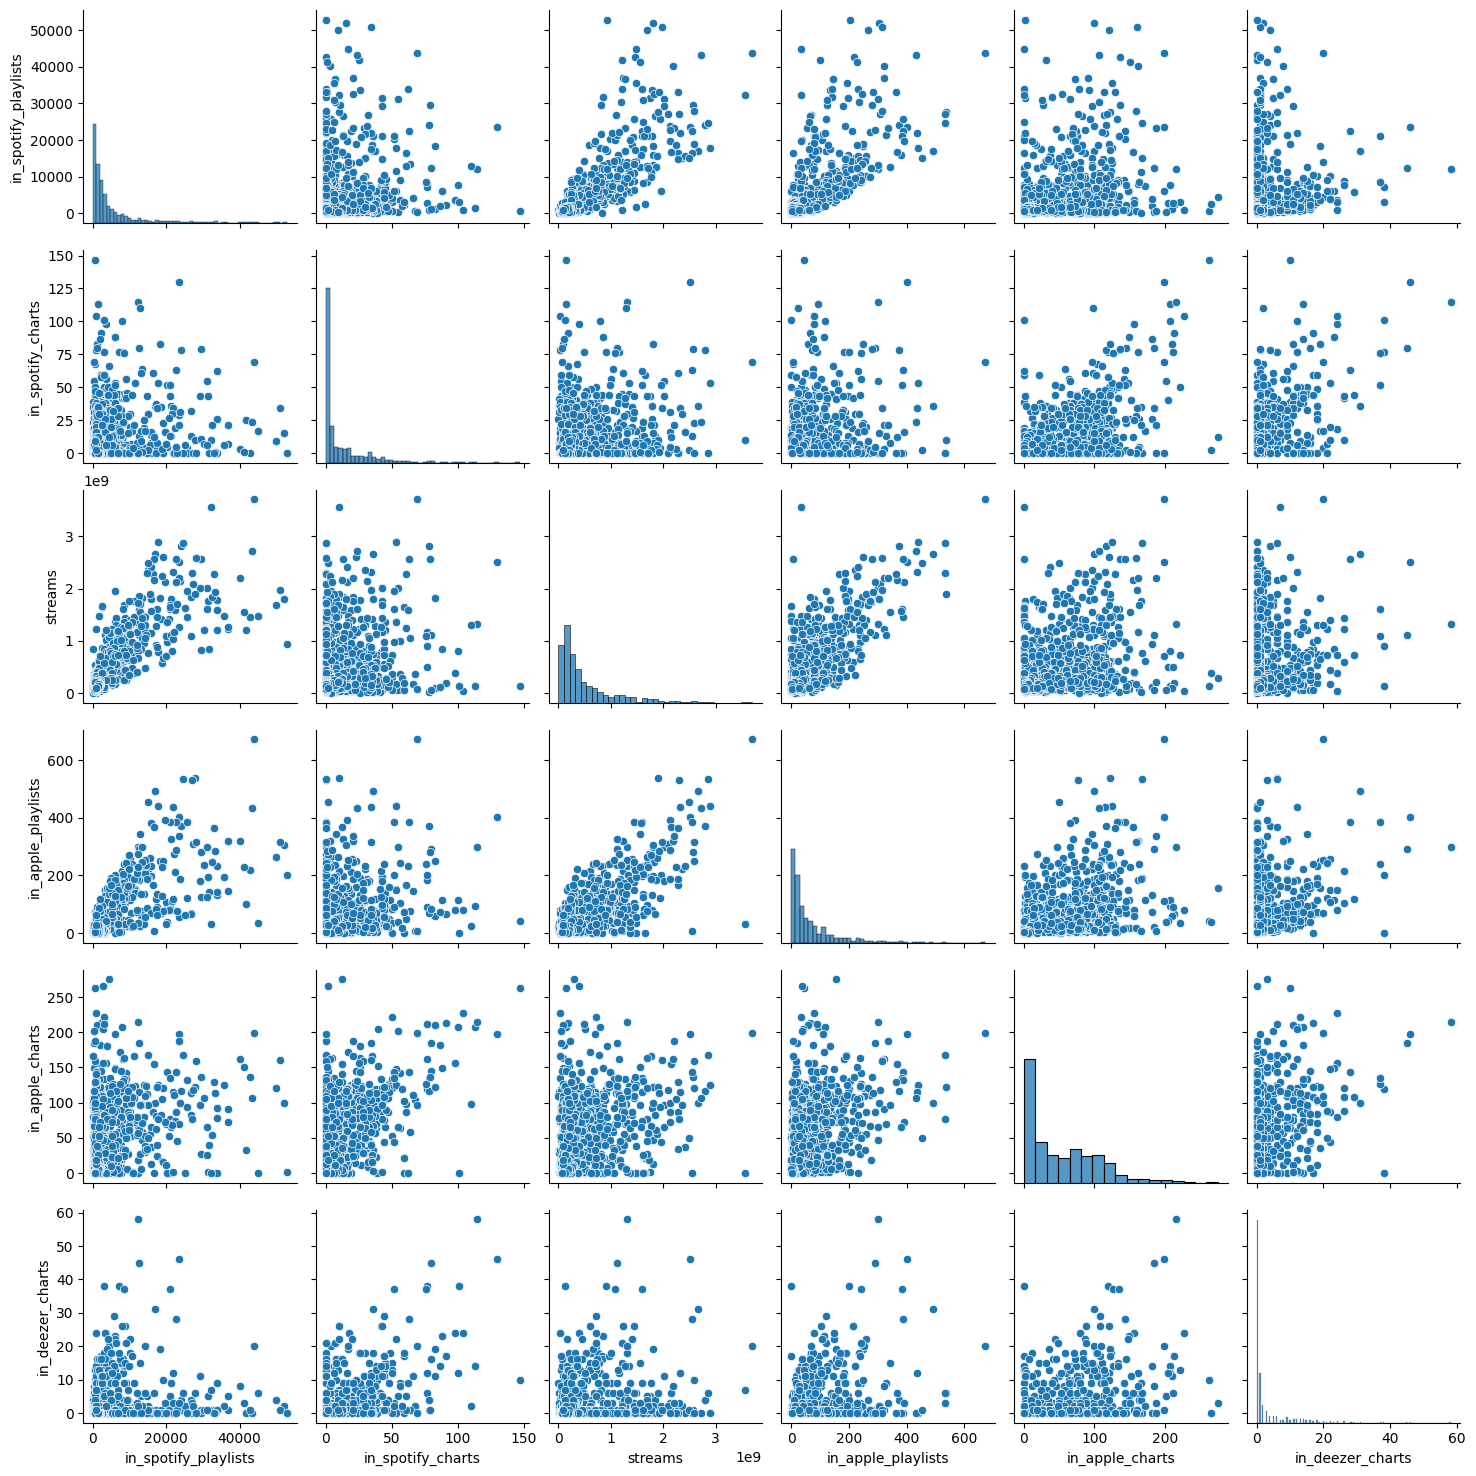

In [11]:
sns.pairplot(music_num, vars=music_num.columns[4:10])

<Axes: >

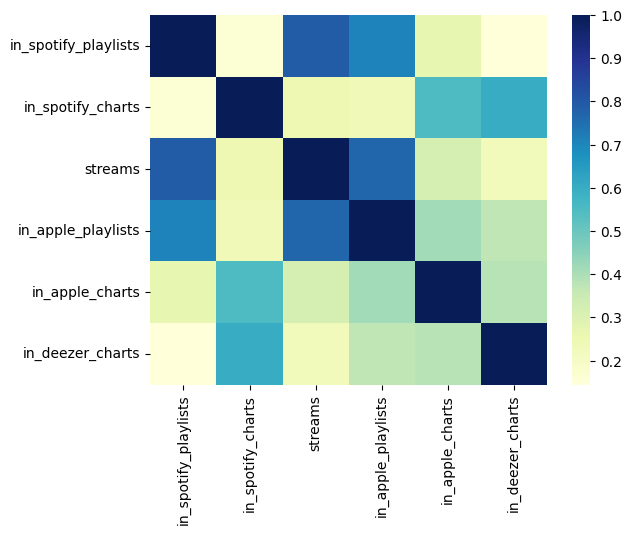

In [12]:
subset = music_num.columns[4:10]
subset = music_num[subset]
sns.heatmap(subset.corr(), cmap="YlGnBu")

In [13]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [14]:
model = LinearRegression()
X = music[['in_spotify_playlists','in_apple_playlists']]  
y = music['streams'] 
model.fit(X, y)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
r_squared = model.score(X, y)
print("R-squared:", r_squared)
import statsmodels.api as sm
X_with_const = sm.add_constant(X)

model_stats = sm.OLS(y, X_with_const).fit()

print(model_stats.summary())

Coefficients: [  34980.62127509 2797363.96226807]
Intercept: 142300892.9269504
R-squared: 0.7145677683310974
                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     1188.
Date:                Sun, 26 Nov 2023   Prob (F-statistic):          4.33e-259
Time:                        18:04:21   Log-Likelihood:                -19942.
No. Observations:                 952   AIC:                         3.989e+04
Df Residuals:                     949   BIC:                         3.990e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------

c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


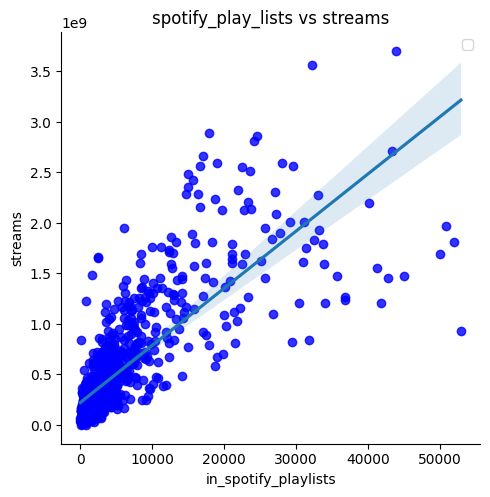

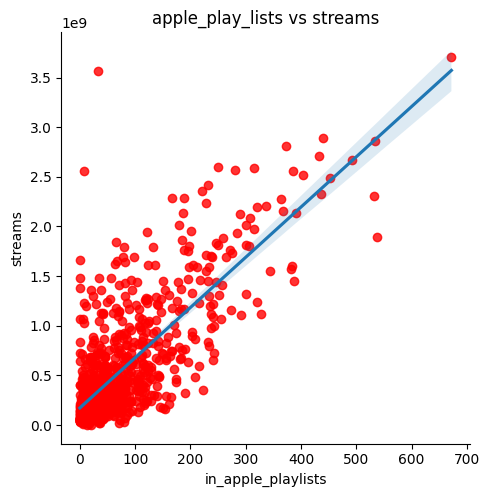

In [28]:
X1 = music['in_spotify_playlists'].values.reshape(-1, 1)
y1 = music['streams']
X2 = music['in_apple_playlists'].values.reshape(-1, 1)
y2 = music['streams']
modelX1 = LinearRegression()
model2 = LinearRegression()
model1.fit(X1, y1)
model2.fit(X2, y2)
lmplot1 = sns.lmplot(x='in_spotify_playlists', y='streams', data=music, scatter_kws={'color': 'blue'}).set(title = 'spotify_play_lists vs streams')
lmplot2 = sns.lmplot(x='in_apple_playlists', y='streams', data=music, scatter_kws={'color': 'red'}).set(title = 'apple_play_lists vs streams')
ax1 = lmplot1.axes[0, 0]
ax2 = lmplot2.axes[0, 0]
ax1.legend()
plt.show()

In [18]:
model = LinearRegression()
X = music[['in_spotify_charts','in_apple_charts']]  
y = music['streams'] 
model.fit(X, y)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
r_squared = model.score(X, y)
print("R-squared:", r_squared)
import statsmodels.api as sm
X_with_const = sm.add_constant(X)

model_stats = sm.OLS(y, X_with_const).fit()

print(model_stats.summary())

Coefficients: [2874964.07263975 2971645.59139955]
Intercept: 325158118.66564476
R-squared: 0.10940854389555354
                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     58.29
Date:                Sun, 26 Nov 2023   Prob (F-statistic):           1.33e-24
Time:                        18:04:23   Log-Likelihood:                -20483.
No. Observations:                 952   AIC:                         4.097e+04
Df Residuals:                     949   BIC:                         4.099e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------

c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\jakehays\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


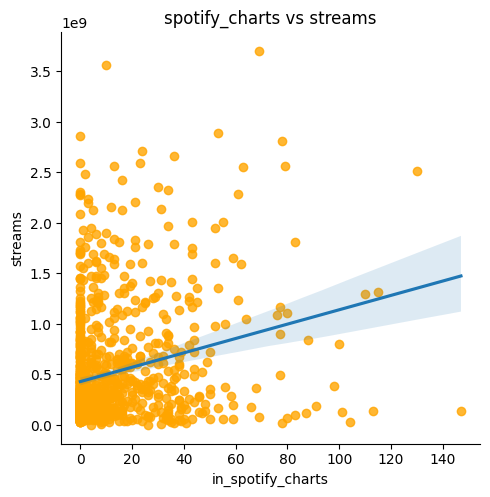

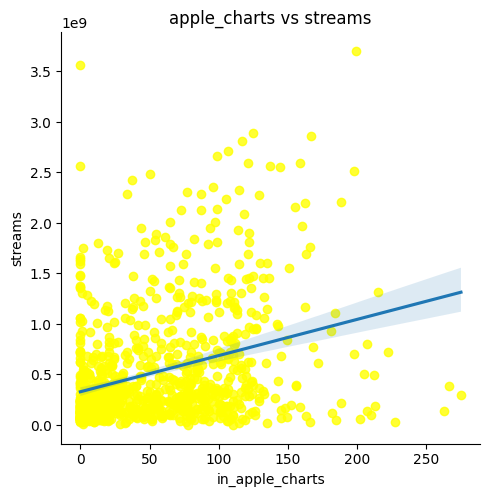

In [27]:
X1 = music['in_spotify_charts'].values.reshape(-1, 1)
y1 = music['streams']
X2 = music['in_apple_charts'].values.reshape(-1, 1)
y2 = music['streams']
model1 = LinearRegression()
model2 = LinearRegression()
model1.fit(X1, y1)
model2.fit(X2, y2)
sns.lmplot(x='in_spotify_charts', y='streams', data=music, scatter_kws={'color': 'orange'}).set(title = 'spotify_charts vs streams')
sns.lmplot(x='in_apple_charts', y='streams', data=music, scatter_kws={'color': 'yellow'}).set( title = 'apple_charts vs streams')